In [ ]:
# Initialization: Load shared functions and simulated data

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   119k      0 --:--:-- --:--:-- --:--:--  119k


<Figure size 640x480 with 0 Axes>

In [ ]:
# Load data from the 2018-07-25 to the 2018-08-14

DIR_INPUT='./simulated-data-transformed/data/'

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: user 106 ms, sys: 56.6 ms, total: 163 ms
Wall time: 162 ms
201295 transactions loaded, containing 1792 fraudulent transactions


In [ ]:
# Compute the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_tx_stats(transactions_df, start_date_df="2018-04-01"):

    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraudulent_transactions_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of compromised cards per day
    nb_compromised_cards_per_day=transactions_df[transactions_df['TX_FRAUD']==1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()

    tx_stats=pd.DataFrame({"nb_tx_per_day":nb_tx_per_day,
                           "nb_fraudulent_transactions_per_day":nb_fraudulent_transactions_per_day,
                           "nb_compromised_cards_per_day":nb_compromised_cards_per_day})

    tx_stats=tx_stats.reset_index()

    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)

    tx_stats['tx_date']=tx_date

    return tx_stats

tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

In [ ]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_template_tx_stats(ax ,fs,
                          start_date_training,
                          title='',
                          delta_train=7,
                          delta_delay=7,
                          delta_test=7,
                          ylim=300):

    ax.set_title(title, fontsize=fs*1.5)
    ax.set_ylim([0, ylim])

    ax.set_xlabel('Date', fontsize=fs)
    ax.set_ylabel('Number', fontsize=fs)

    plt.yticks(fontsize=fs*0.7)
    plt.xticks(fontsize=fs*0.7)

    ax.axvline(start_date_training+datetime.timedelta(days=delta_train), 0,ylim, color="black")
    ax.axvline(start_date_test, 0, ylim, color="black")

    ax.text(start_date_training+datetime.timedelta(days=2), ylim-20,'Training period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+2), ylim-20,'Delay period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+delta_delay+2), ylim-20,'Test period', fontsize=fs)


cmap = plt.get_cmap('jet')
colors={'nb_tx_per_day':cmap(0),
        'nb_fraudulent_transactions_per_day':cmap(200),
        'nb_compromised_cards_per_day':cmap(250)}

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Total transactions, and number of fraudulent transactions \n and number of compromised cards per day',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
ax.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day'], 'b', color=colors['nb_compromised_cards_per_day'], label = '# compromised cards per day')

ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)

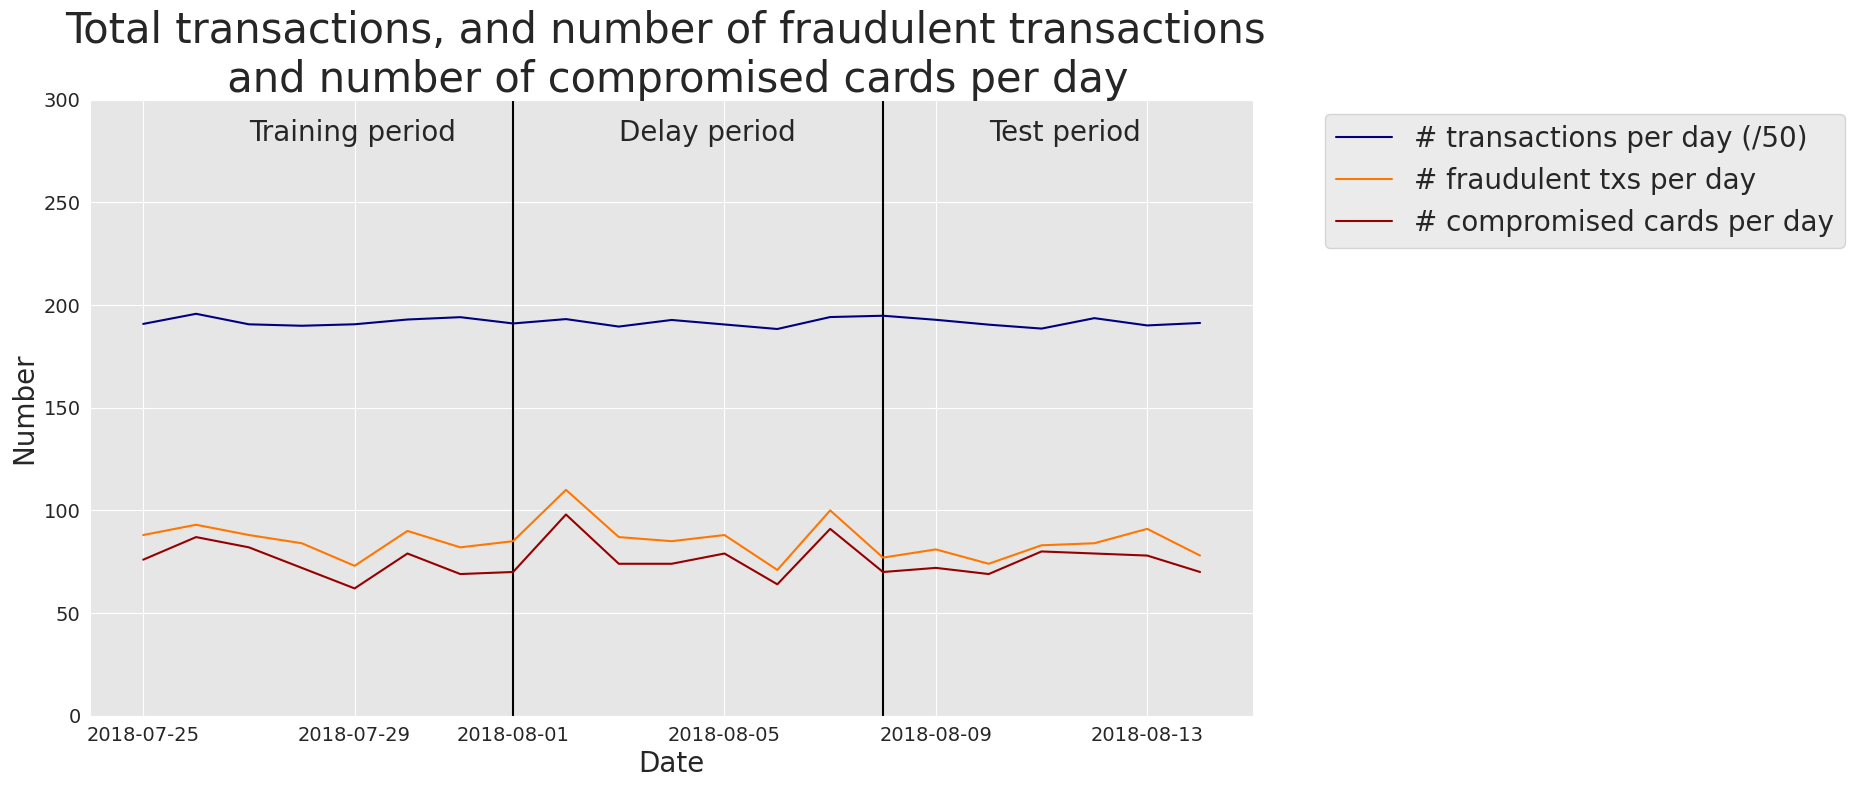

In [ ]:
fraud_and_transactions_stats_fig

In [ ]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7):

    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]

    # Get the test set data
    test_df = []

    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed

    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)

    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()

    # Then, for each day of the test set
    for day in range(delta_test):

        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]

        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]

        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)

        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]

        test_df.append(test_df_day)

    test_df = pd.concat(test_df)

    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')

    return (train_df, test_df)

In [ ]:
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

In [ ]:
train_df.shape
#total number of transactions

(67240, 23)

In [ ]:
train_df[train_df.TX_FRAUD==1].shape
#Total number of fraud transactions

(598, 23)

In [ ]:
test_df.shape
#Testing dataset total number of transactions

(58264, 23)

In [ ]:
test_df[test_df.TX_FRAUD==1].shape
#Total number of fraud transactions in test dataset

(385, 23)

In [ ]:
385/58264

0.00660785390635727

Above is a proportion of 0.007 fraudulent transactions.

In [ ]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

In [ ]:
def fit_model_and_get_predictions(classifier, train_df, test_df,
                                  input_features, output_feature="TX_FRAUD",scale=True):

    # By default, scales input data
    if scale:
        (train_df, test_df)=scaleData(train_df,test_df,input_features)

    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time

    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models,
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }

    return model_and_predictions_dictionary

In [ ]:
# We first create a decision tree object. We will limit its depth to 2 for interpretability,
# and set the random state to zero for reproducibility
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df,
                                                                 input_features, output_feature,
                                                                 scale=False)

In [ ]:
test_df['TX_FRAUD_PREDICTED']=model_and_predictions_dictionary['predictions_test']
test_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED
134215,1236698,2018-08-08 00:01:14,2765,2747,42.32,11145674,129,0,0,0,...,67.468529,120.0,64.611750,2.0,0.0,9.0,0.0,31.0,0.000000,0.003536
134216,1236699,2018-08-08 00:02:33,714,2073,108.19,11145753,129,0,0,0,...,79.955455,124.0,85.365645,2.0,0.0,10.0,0.0,23.0,0.000000,0.003536
134218,1236701,2018-08-08 00:08:40,4982,1258,26.13,11146120,129,0,0,0,...,56.269167,61.0,49.095902,1.0,0.0,10.0,0.0,26.0,0.076923,0.003536
134219,1236702,2018-08-08 00:08:41,704,8501,65.81,11146121,129,0,0,0,...,62.643333,11.0,63.287273,1.0,0.0,6.0,0.0,23.0,0.000000,0.003536
134220,1236703,2018-08-08 00:10:34,3085,4208,55.22,11146234,129,0,0,0,...,71.993846,72.0,59.899306,1.0,0.0,5.0,0.0,21.0,0.523810,0.003536


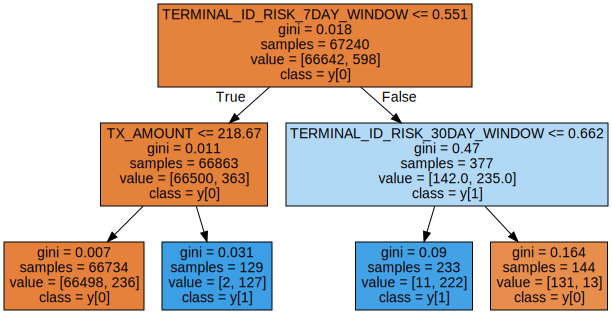

In [ ]:
display(graphviz.Source(sklearn.tree.export_graphviz(classifier,feature_names=input_features,class_names=True, filled=True)))

In [ ]:
def card_precision_top_k_day(df_day,top_k):

    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID,
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)

    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_compromised_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)

    # Compute precision top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k

    return list_detected_compromised_cards, card_precision_top_k

def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()

    # At first, the list of detected compromised cards is empty
    list_detected_compromised_cards = []

    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []

    # For each day, compute precision top k
    for day in list_days:

        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]

        # Let us remove detected compromised cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]

        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))

        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)

        card_precision_top_k_per_day_list.append(card_precision_top_k)

        # Let us update the list of detected compromised cards
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)

    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()

    # Returns precision top k per day as a list, and resulting mean
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD',
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):

    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])

    performances = pd.DataFrame([[AUC_ROC, AP]],
                           columns=['AUC ROC','Average precision'])

    for top_k in top_k_list:

        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k

    if rounded:
        performances = performances.round(3)

    return performances

In [ ]:
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']

performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.763,0.496,0.241


In [ ]:
predictions_df['predictions']=0.5

performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.5,0.007,0.017


The most interpretable metric is the Card Precision@100, which tells us that every day, 24% of the cards with the highest fraudulent scores were indeed compromised. Since the percentage of frauds in the test set is 0.7%, this proportion of detected frauds is high and means that the classifier indeed manages to do much better than chance.

It is known that a random classifier would give an AUC ROC of 0.5, and an Average Precision of 0.007 (the proportion of frauds in the test set). The obtained values are much higher (0.764) and (0.496), confirming the ability of the classifier to provide much better predictions than a random model. A random models probability would be 0.5(50%)

Besides the decision tree with depth 2, we will train four other prediction models: a decision tree with unlimited depth, a logistic regression model, a random forest, and a boosting model. These models are the most commonly used in benchmarks in the fraud detection literature

In [ ]:
classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0),
                        'Decision tree with depth of two':sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0),
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(random_state=0),
                        'Random forest':sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1),
                        'xgboost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:

    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df,
                                                                                  input_features=input_features,
                                                                                output_feature=output_feature)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions

In [ ]:
def performance_assessment_model_collection(fitted_models_and_predictions_dictionary,
                                            transactions_df,
                                            type_set='test',
                                            top_k_list=[100]):

    performances_list = []  # Initialize an empty list to store DataFrames

    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():

        predictions_df=transactions_df

        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]

        performances_model=performance_assessment(predictions_df, output_feature='TX_FRAUD',
                                                   prediction_feature='predictions', top_k_list=top_k_list)
        performances_model.index=[classifier_name]

        performances_list.append(performances_model)  # Append to the list

    performances = pd.concat(performances_list)  # Concatenate all DataFrames in the list
    return performances

In [ ]:
#performance on test set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df,type_set='test',top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.870,0.605,0.291
Decision tree with depth of two,0.763,0.496,0.241
Decision tree - unlimited depth,0.788,0.309,0.243
Random forest,0.867,0.658,0.287
xgboost,0.875,0.605,0.271


In [ ]:
# @title AUC ROC

from matplotlib import pyplot as plt
df_performances['AUC ROC'].plot(kind='line', figsize=(15, 6), title='AUC ROC')
plt.gca().spines[['top', 'right']].set_visible(False)

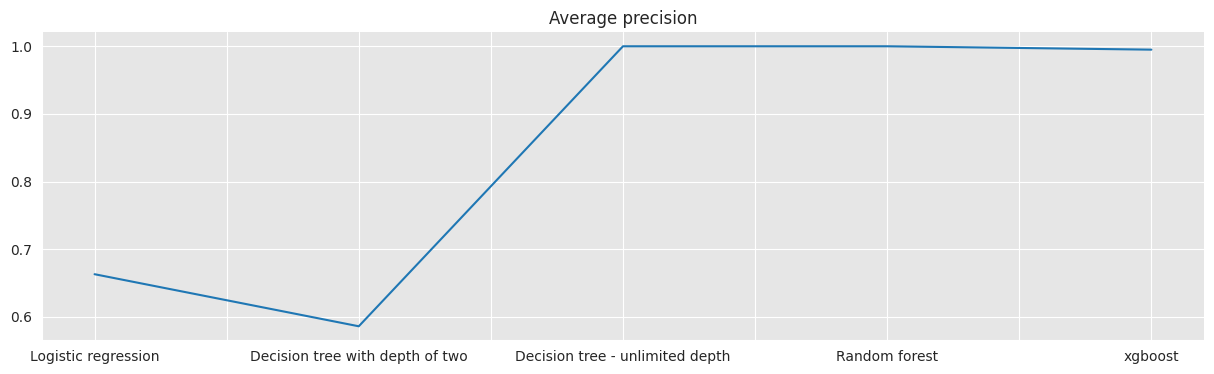

In [ ]:
# @title Average Precision

from matplotlib import pyplot as plt
df_performances['Average precision'].plot(kind='line', figsize=(15, 4), title='Average precision')
plt.gca().spines[['top', 'right']].set_visible(False)

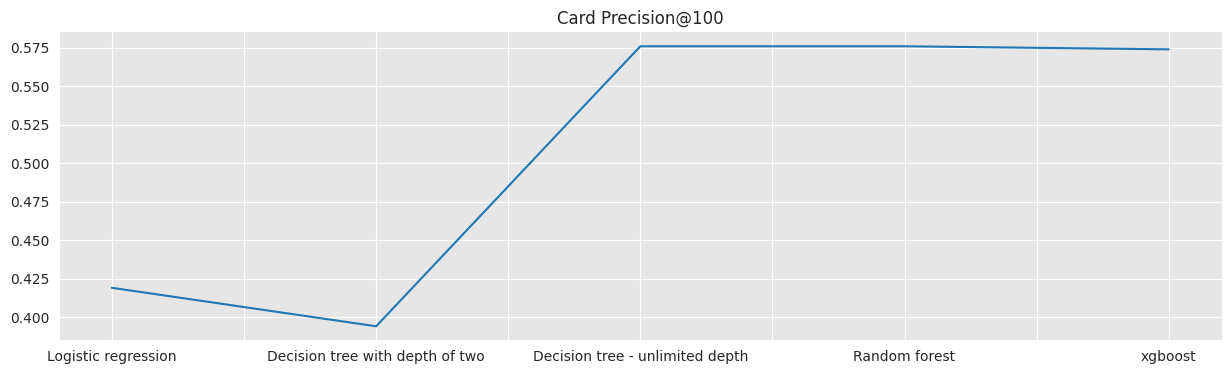

In [ ]:
# @title Card Precision@100

from matplotlib import pyplot as plt
df_performances['Card Precision@100'].plot(kind='line', figsize=(15, 4), title='Card Precision@100')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# performances on training set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, train_df,
                                                        type_set='train',
                                                        top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.892,0.663,0.419
Decision tree with depth of two,0.802,0.586,0.394
Decision tree - unlimited depth,1.000,1.000,0.576
Random forest,1.000,1.000,0.576
xgboost,1.000,0.995,0.574


In [ ]:
def execution_times_model_collection(fitted_models_and_predictions_dictionary):

    execution_times_list = []  # Initialize an empty list to store DataFrames

    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():

        execution_times_model = pd.DataFrame({
            'Training execution time': [model_and_predictions['training_execution_time']],
            'Prediction execution time': [model_and_predictions['prediction_execution_time']]
        })
        execution_times_model.index = [classifier_name]

        execution_times_list.append(execution_times_model)  # Append to the list

    execution_times = pd.concat(execution_times_list)  # Concatenate all DataFrames in the list
    return execution_times

In [ ]:
# Execution times
df_execution_times=execution_times_model_collection(fitted_models_and_predictions_dictionary)
df_execution_times

,Training execution time,Prediction execution time
Logistic regression,0.170148,0.012738
Decision tree with depth of two,0.175269,0.013040
Decision tree - unlimited depth,1.451422,0.014948
Random forest,15.335788,0.457624
xgboost,0.681733,0.216786


All prediction models have learned useful fraud patterns from the training data. This can be seen from the AUC ROC on the test set, which is higher than 0.5 for all classifiers, and an average precision much higher than 0.007.

The random forest and boosting models provide better performances (in terms of Average Precision) than logistic regression and decision trees. This is also widely reported in the fraud detection literature.

The relative performances of the classifiers differ depending on which performance metrics is used. For example, a decision tree of depth 2 has a lower AUC ROC than a decision tree of unlimited depth, but a higher average precision.

The performance of some classifiers (Random Forest and Decision Tree with unlimited depth) is perfect on the training set (AUC ROC and Average Precision of 1), but lower on the test set. In fact, the decision tree with unlimited depth is actually the worst classifier on the test set in terms of Average Precision. This is an example of a phenomenon called overfitting, which should be avoided.

As expected, the execution times for training ensembles of models (Random forest and XGBoost) is significantly higher than single models (decision trees and logistic regression).

The models the least sensitive to overfitting are the logistic regression model, and the decision tree with depth 2. It makes sense that the training metrics of tree-based models with unlimited depth (Random Forest, Decision Tree) achieve perfect detection because, during training, these models will split data recursively until obtention of pure leaves.

The recall, specificity, precision, and F1 score metrics, also known as threshold-based metrics, have well-known limitations due to their dependence on a decision threshold which is difficult to determine in practice, and strongly depends on the business-specific constraints. They are often complemented with the AUC ROC, and more recently, the Average Precision (AP) metrics. The AUC ROC and AP metrics aim at assessing, with a single number, the performance for all possible decision thresholds, and are referred to as threshold-free metrics. The AUC ROC is currently the de-facto metric for assessing fraud detection accuracies. Recent research has however shown that this metric is also misleading for assessing highly imbalanced problems such as fraud detection, and recommended using the Precision-Recall curve and AP metric instead

In [ ]:
test_df.to_csv('test_df.csv')

The input_data in cell 28 is a dictionary containing the features used by the trained fraud detection models to predict whether a transaction is fraudulent.

Transaction-specific features:

1. TX_AMOUNT: The transaction amount.
2. TX_DURING_WEEKEND: A binary feature indicating whether the transaction occurred during the weekend (1) or not (0).
3. TX_DURING_NIGHT: A binary feature indicating whether the transaction occurred during the night (1) or not (0).

Customer-specific features:
These features capture the customer's transaction history over different time windows (1 day, 7 days, and 30 days):

1. CUSTOMER_ID_NB_TX_1DAY_WINDOW: Number of transactions by the customer in the last 24 hours.
2. CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW: Average transaction amount by the customer in the last 24 hours.
3. CUSTOMER_ID_NB_TX_7DAY_WINDOW: Number of transactions by the customer in the last 7 days.
4. CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW: Average transaction amount by the customer in the last 7 days.
5. CUSTOMER_ID_NB_TX_30DAY_WINDOW: Number of transactions by the customer in the last 30 days.
6. CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW: Average transaction amount by the customer in the last 30 days.

Terminal-specific features:
These features describe the transaction terminal's activity and risk level over different time windows (1 day, 7 days, and 30 days):

1. TERMINAL_ID_NB_TX_1DAY_WINDOW: Number of transactions at the terminal in the last 24 hours.
2. TERMINAL_ID_RISK_1DAY_WINDOW: Risk score associated with the terminal in the last 24 hours.
3. TERMINAL_ID_NB_TX_7DAY_WINDOW: Number of transactions at the terminal in the last 7 days.
4. TERMINAL_ID_RISK_7DAY_WINDOW: Risk score associated with the terminal in the last 7 days.
5. TERMINAL_ID_NB_TX_30DAY_WINDOW: Number of transactions at the terminal in the last 30 days.
6. TERMINAL_ID_RISK_30DAY_WINDOW: Risk score associated with the terminal in the last 30 days.

These features are used as input to the trained models in fitted_models_and_predictions_dictionary to predict the likelihood of a transaction being fraudulent.

In [ ]:
def predict_fraud(fitted_models_and_predictions_dictionary, input_data):
  """Predicts if a transaction is fraud using trained models.

  Args:
    fitted_models_and_predictions_dictionary: A dictionary containing trained models.
    input_data: A dictionary representing the input features of a transaction.

  Returns:
    A dictionary containing fraud predictions from different models.
  """

  predictions = {}
  for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    classifier = model_and_predictions['classifier']
    prediction = classifier.predict_proba([list(input_data.values())])[0][1]
    predictions[classifier_name] = prediction

  return predictions


# Example usage:
input_data = {
    'TX_AMOUNT': 300,
    'TX_DURING_WEEKEND': 0,
    'TX_DURING_NIGHT': 0,
    'CUSTOMER_ID_NB_TX_1DAY_WINDOW': 5,
    'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW': 5,
    'CUSTOMER_ID_NB_TX_7DAY_WINDOW': 20,
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW': 60,
    'CUSTOMER_ID_NB_TX_30DAY_WINDOW': 80,
    'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW': 70,
    'TERMINAL_ID_NB_TX_1DAY_WINDOW': 10,
    'TERMINAL_ID_RISK_1DAY_WINDOW': 0.2,#its in point 0.2
    'TERMINAL_ID_NB_TX_7DAY_WINDOW': 40,
    'TERMINAL_ID_RISK_7DAY_WINDOW': 0.3, #in point 0.3
    'TERMINAL_ID_NB_TX_30DAY_WINDOW': 150,
    'TERMINAL_ID_RISK_30DAY_WINDOW': 0.4,
}

fraud_predictions = predict_fraud(fitted_models_and_predictions_dictionary, input_data)
print("Fraud Predictions:", fraud_predictions)
print("Logistic regression:", fraud_predictions['Logistic regression'])
print("Decision tree with depth of two:", fraud_predictions['Decision tree with depth of two'])
print("Decision tree - unlimited depth:", fraud_predictions['Decision tree - unlimited depth'])
print("Random forest:", fraud_predictions['Random forest'])
print("xgboost:", fraud_predictions['xgboost'])

Fraud Predictions: {'Logistic regression': 1.0, 'Decision tree with depth of two': 0.9844961240310077, 'Decision tree - unlimited depth': 1.0, 'Random forest': 0.82, 'xgboost': 0.9623562}
Logistic regression: 1.0
Decision tree with depth of two: 0.9844961240310077
Decision tree - unlimited depth: 1.0
Random forest: 0.82
xgboost: 0.9623562


In [ ]:
def predict_fraud(fitted_models_and_predictions_dictionary, input_data):
    predictions = {}
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
        classifier = model_and_predictions['classifier']
        prediction = classifier.predict_proba([list(input_data.values())])[0][1]
        predictions[classifier_name] = prediction
        # Print classifier name, predicted value, and label
        label = "fraud" if prediction > 0.5 else "non-fraudulent"
        print(f"{classifier_name}: Predicted Value = {prediction:.4f}, Label = {label}")
    return predictions
input_data = {
    'TX_AMOUNT': 5,
    'TX_DURING_WEEKEND': 0,
    'TX_DURING_NIGHT': 0,
    'CUSTOMER_ID_NB_TX_1DAY_WINDOW': 5,
    'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW': 5,
    'CUSTOMER_ID_NB_TX_7DAY_WINDOW': 20,
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW': 60,
    'CUSTOMER_ID_NB_TX_30DAY_WINDOW': 80,
    'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW': 70,
    'TERMINAL_ID_NB_TX_1DAY_WINDOW': 10,
    'TERMINAL_ID_RISK_1DAY_WINDOW': 0.2,#its in point 0.2
    'TERMINAL_ID_NB_TX_7DAY_WINDOW': 40,
    'TERMINAL_ID_RISK_7DAY_WINDOW': 0.3, #in point 0.3
    'TERMINAL_ID_NB_TX_30DAY_WINDOW': 150,
    'TERMINAL_ID_RISK_30DAY_WINDOW': 0.4,
}
fraud_predictions = predict_fraud(fitted_models_and_predictions_dictionary, input_data)

Logistic regression: Predicted Value = 0.0000, Label = non-fraudulent
Decision tree with depth of two: Predicted Value = 0.9845, Label = fraud
Decision tree - unlimited depth: Predicted Value = 1.0000, Label = fraud
Random forest: Predicted Value = 0.7900, Label = fraud
xgboost: Predicted Value = 0.9624, Label = fraud


In [ ]:
import pickle

# Assuming `fitted_models_and_predictions_dictionary` contains your trained models

# Save the dictionary with models to a file
with open('CCFD_model.pkl', 'wb') as file:
    pickle.dump(fitted_models_and_predictions_dictionary, file)

print("Models saved successfully!")

Models saved successfully!


In [1]:
import pickle
# Load the dictionary with models from the .pkl file
with open('CCFD_model.pkl', 'rb') as file:
    fitted_models_and_predictions_dictionary = pickle.load(file)

print("Models loaded successfully!")


d:\Python\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results.

Models loaded successfully!


d:\Python\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:05:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [3]:
import streamlit as st
import pickle

# Load your trained models
with open('CCFD_model.pkl', 'rb') as file:
    fitted_models_and_predictions_dictionary = pickle.load(file)

def predict_fraud(input_data):
    predictions = {}
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
        classifier = model_and_predictions['classifier']
        prediction = classifier.predict_proba([list(input_data.values())])[0][1]
        predictions[classifier_name] = prediction
    return predictions

# Streamlit UI
st.title("Fraud Detection Model")

# Inputs from user
tx_amount = st.number_input('Transaction Amount', value=300)
tx_during_weekend = st.selectbox('Transaction During Weekend?', [0, 1])
tx_during_night = st.selectbox('Transaction During Night?', [0, 1])
customer_nb_tx_1day_window = st.number_input('Customer TX 1-day window', value=5)
customer_avg_amount_1day_window = st.number_input('Customer Avg Amount 1-day window', value=5)
customer_nb_tx_7day_window = st.number_input('Customer TX 7-day window', value=20)
customer_avg_amount_7day_window = st.number_input('Customer Avg Amount 7-day window', value=60)
customer_nb_tx_30day_window = st.number_input('Customer TX 30-day window', value=80)
customer_avg_amount_30day_window = st.number_input('Customer Avg Amount 30-day window', value=70)
terminal_nb_tx_1day_window = st.number_input('Terminal TX 1-day window', value=10)
terminal_risk_1day_window = st.number_input('Terminal Risk 1-day window', value=0.2)
terminal_nb_tx_7day_window = st.number_input('Terminal TX 7-day window', value=40)
terminal_risk_7day_window = st.number_input('Terminal Risk 7-day window', value=0.3)
terminal_nb_tx_30day_window = st.number_input('Terminal TX 30-day window', value=150)
terminal_risk_30day_window = st.number_input('Terminal Risk 30-day window', value=0.4)

# Predict button
if st.button("Predict"):
    input_data = {
        'TX_AMOUNT': tx_amount,
        'TX_DURING_WEEKEND': tx_during_weekend,
        'TX_DURING_NIGHT': tx_during_night,
        'CUSTOMER_ID_NB_TX_1DAY_WINDOW': customer_nb_tx_1day_window,
        'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW': customer_avg_amount_1day_window,
        'CUSTOMER_ID_NB_TX_7DAY_WINDOW': customer_nb_tx_7day_window,
        'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW': customer_avg_amount_7day_window,
        'CUSTOMER_ID_NB_TX_30DAY_WINDOW': customer_nb_tx_30day_window,
        'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW': customer_avg_amount_30day_window,
        'TERMINAL_ID_NB_TX_1DAY_WINDOW': terminal_nb_tx_1day_window,
        'TERMINAL_ID_RISK_1DAY_WINDOW': terminal_risk_1day_window,#its in point 0.2
        'TERMINAL_ID_NB_TX_7DAY_WINDOW': terminal_nb_tx_7day_window,
        'TERMINAL_ID_RISK_7DAY_WINDOW': terminal_risk_7day_window, #in point 0.3
        'TERMINAL_ID_NB_TX_30DAY_WINDOW': terminal_nb_tx_30day_window,
        'TERMINAL_ID_RISK_30DAY_WINDOW': terminal_risk_30day_window,
    }
    predictions = predict_fraud(input_data)
    st.write("Fraud Predictions:", predictions)

d:\Python\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results.

In [6]:
!streamlit run CCFD_script.py --server.port 8501

^C
